# OTUs-metabolites Matrix

The final step of the work consists of associating the OTUs to the metabolites of a specific pathway.
Since the first script `1-pathway-otus.ipynb` links OTUs abundancies to a specific pathway and the second one `2-metacyc-score.ipynb` each pathway to their consumed/produced metabolites, by joining this overlapping information it is possible to achieve this goal.
We show in the paper that this is obtained by a simple matrix product.

In [1]:
import html
import matplotlib.pyplot as plt
import matplotlib.colors # https://matplotlib.org/2.0.2/users/colormaps.html
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

# Be sure the code is correct when excluding warnings!
import warnings
warnings.filterwarnings("ignore") # ignore boring warnings

In [2]:
# Minor plot tweaks
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']});
matplotlib.rc('text', usetex=True);

sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

## Autism Spectrum Disorder [(ASD)](https://www.wikiwand.com/en/Autism_spectrum)

In [3]:
# Read files
filesToRead = glob("tmp/asd/Pathway_Host*_index.csv")
dfMetaboliteScore = pd.read_csv("tmp/asd/Pathway_reactions_score_table.csv", sep=";", on_bad_lines="skip")

Some pathways have the same metabolite appearing both on the left-hand side and on the right-hand side.
Thus, they display both positive and negative score, accordingly to the reaction.
We shall then sum the total score for the same reagent per pathway (exploiting their `ID`) in order to check the *final balance* of each reagent between in/out in the reaction.
Note that in this way the `dfMetaboliteScore` dataframe almost halves, passing from circa 60 000 rows down to 30 000.

As a consequence, if a reagent has null score (zero) it means that its abundancy is unchanged along the pathway reactions.
Conversely, if the score is positive/negative, then the reagent quantity increases/decreases.

In [4]:
dfMetaboliteScore = dfMetaboliteScore.drop(columns=["Reaction Name", "Pathway"])
# Sum all metabolite scores for fixed reaction ID
dfMetaboliteScore = dfMetaboliteScore.groupby(by=["ID", "Reagent"]).sum()
dfMetaboliteScore.reset_index(inplace=True)
dfMetaboliteScore

,ID,Reagent,Score
0,12DICHLORETHDEG-PWY,2-chloroacetate,1
1,12DICHLORETHDEG-PWY,2-chloroethanol,-1
2,12DICHLORETHDEG-PWY,H+,4
3,12DICHLORETHDEG-PWY,H2O,-1
4,12DICHLORETHDEG-PWY,NAD+,-1
...,...,...,...
39399,XYLCAT-PWY,D-xylulose,-1
39400,XYLCAT-PWY,D-xylulose 5-phosphate,1
39401,XYLCAT-PWY,H+,1
39402,XYLCAT-PWY,alpha-D-xylopyranose,-1


In [5]:
# We want now to widen the database in order to have as rows the reactions of each pathway
# (identified by their `ID`) and as rows the reagents produced/consumed
dfMetaboliteScoreLong = dfMetaboliteScore.pivot(index="ID", columns="Reagent", values="Score").fillna(0)
dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[:, (dfMetaboliteScoreLong.sum(axis=0) != 0)]

In the following we are going to manipulate two specific dataframes obtained in the previous two scripts:
1. `dfOTUs` = dataframe where rows = *ID* and columns = patients (e.g., *Aut.Control_14*). The "original" name in the R script is `filePathOTUMatrix`. The values $M_{ij} \in \mathbb{R}$ represent the OTUs populations and seem ok, i.e. equal/very similar to the R ones.
2. `dfMetaboliteScoreLong` = dataframe where rows = *ID* and columns = compounds (e.g., *alpha-D-glucose 6-phosphate*). The original name in the R script is `MetaboliteScoreSumWideMatrix`. The values $M_{ij} \in \mathbb{Z}$ are the score of the 2nd script and do not match perfectly, some have the sign exchanged, probably due to the score assignment to reversible reactions (e.g. $A + B \leftrightarrow AB$).

In [6]:
for f in filesToRead:
    dfOTUs = pd.read_csv(f)
    # Weird name for the "ID" column... we shall use it as dataframe index
    dfOTUs.set_index(dfOTUs["Unnamed: 0"], inplace=True)
    dfOTUs.drop(columns=["Unnamed: 0"], inplace=True)
    
    # Intersect data and keep only the correct MetaCyc reactions for all dataframes.
    # In this way the two dataframes are conformal and can be multiplied as if they were matrices.
    # Note: dfMetaboliteScoreLong.index is the old "ID" column
    xxx = [x for x in list(dfOTUs.index) if x in list(dfMetaboliteScoreLong.index)] # common indexes
    
    dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[:, (dfMetaboliteScoreLong.sum(axis=0) != 0)]
    dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[xxx]
    dfOTUs = dfOTUs.loc[xxx]
    # Right now `dfMetaboliteScoreLong` and `dfOTUs` have the same rows (same indexes)
    
    # Append side-by-side the two dataframes
    bindMe = pd.concat([dfMetaboliteScoreLong, dfOTUs], axis=1)
    prod = bindMe.T @ bindMe
    
    # Select upper-right block
    prod2 = prod.iloc[0:len(list(dfMetaboliteScoreLong.columns))]
    prod2.drop(dfMetaboliteScoreLong.iloc[:, 0:len(list(dfMetaboliteScoreLong.columns))], inplace=True, axis=1)
    
    nameCut = f[17:-9]+"Metabolite"
    # Select lower-left block
    forLDA = prod.iloc[len(list(dfMetaboliteScoreLong.columns)):]
    forLDA = forLDA.iloc[:, 0:len(list(dfMetaboliteScoreLong.columns))]

In [7]:
# Remove boring rows summing to zero
prod2 = prod2.loc[(prod2.sum(axis=1) != 0)]

# Final Patient-Metabolite matrix
prod2
prod2.to_csv("asd/patient-metabolite-matrix.csv")

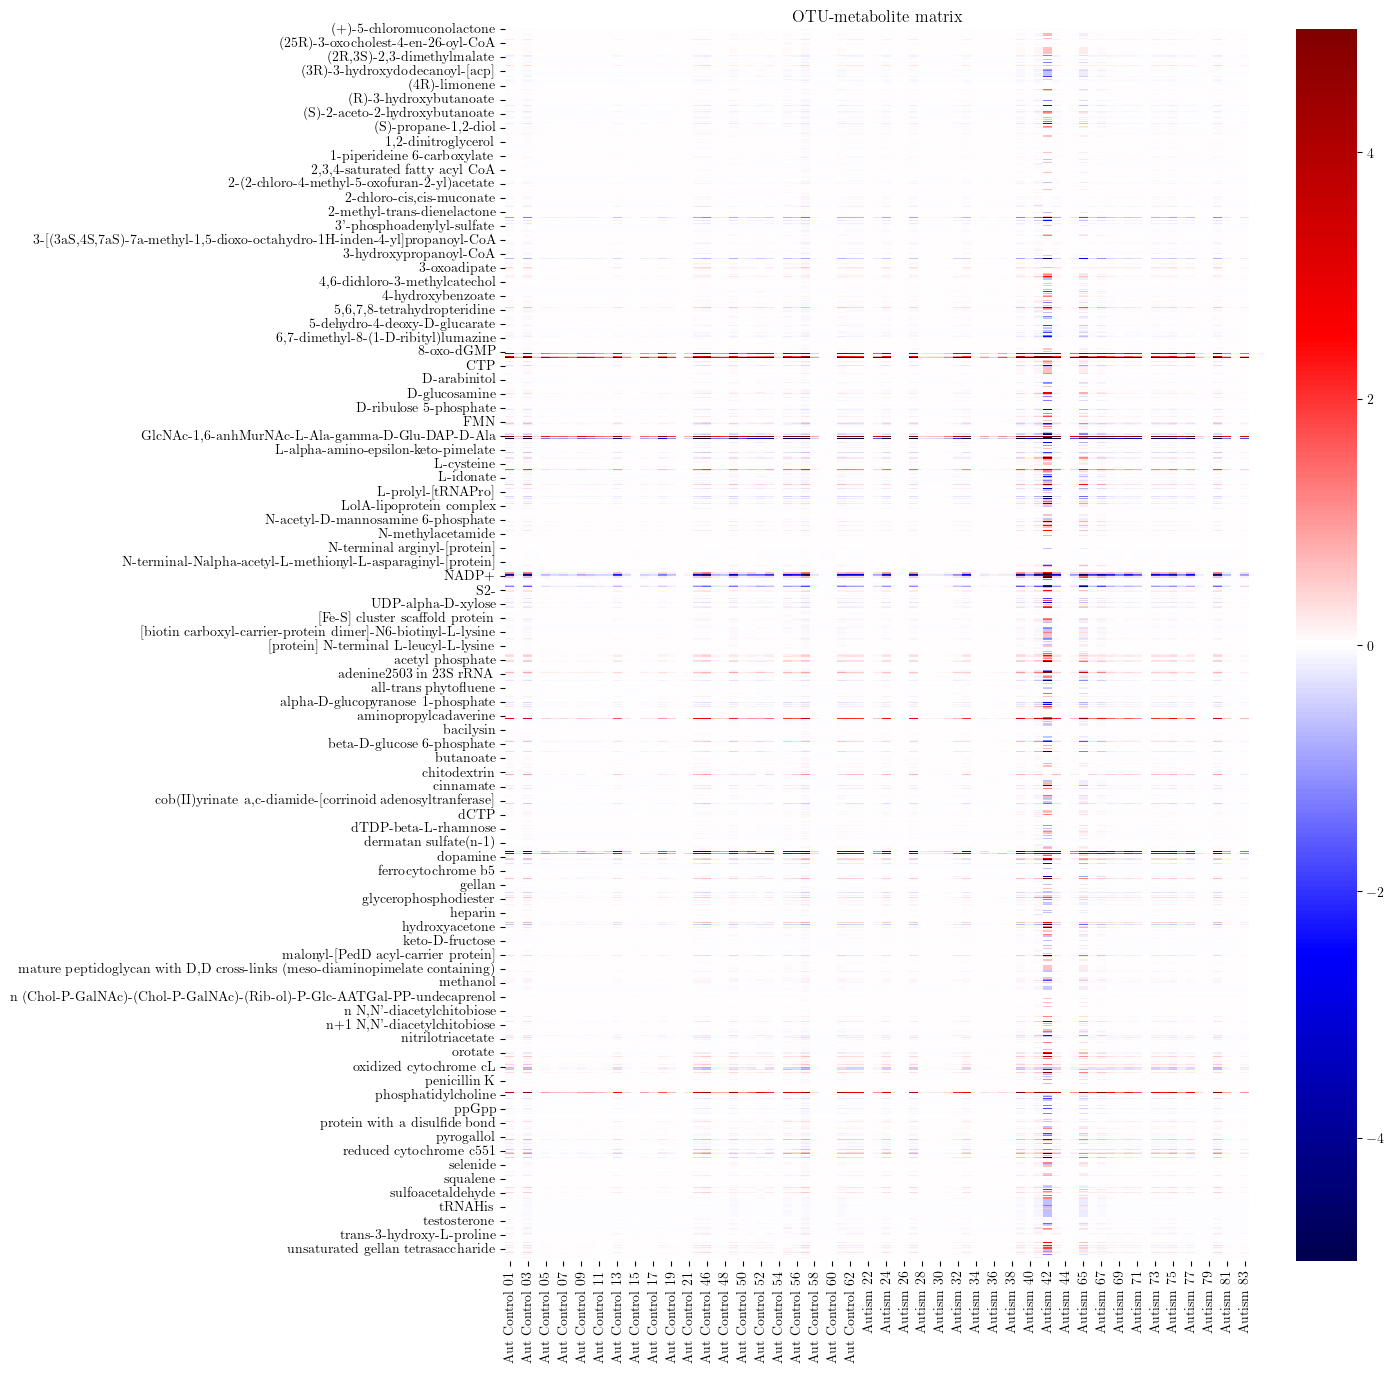

In [8]:
# Figure parameters
ax = plt.subplots(figsize=(12, 16))
plt.title("OTU-metabolite matrix")

# Plot
sns.heatmap(prod2, vmin=-5, vmax=5, cmap="seismic");
plt.savefig("plots/otu-metabolite-matrix-ASD.pdf", bbox_inches="tight")

![Syndrome divider](pix/divider1.svg "")

## Multiple Sclerosis Syndrome [(MS)](https://www.wikiwand.com/en/Multiple_sclerosis)
This section's goal is to obtain the patwhay-OTUs matrix for patients affected by MS, essentially following the steps of the previous one.

In [9]:
# Read files
filesToRead = glob("tmp/ms/Pathway_Host*_index.csv")
dfMetaboliteScore = pd.read_csv("tmp/ms/Pathway_reactions_score_table.csv", sep=";", on_bad_lines="skip")

Some pathways have the same metabolite appearing both on the left-hand side and on the right-hand side.
Thus, they display both positive and negative score, accordingly to the reaction.
We shall then sum the total score for the same reagent per pathway (exploiting their `ID`) in order to check the *final balance* of each reagent between in/out in the reaction.
Note that in this way the `dfMetaboliteScore` dataframe almost halves, passing from circa 60 000 rows down to 30 000.

As a consequence, if a reagent has null score (zero) it means that its abundancy is unchanged along the pathway reactions.
Conversely, if the score is positive/negative then the reagent quantity will increase/decrease.

In [10]:
dfMetaboliteScore = dfMetaboliteScore.drop(columns=["Reaction Name", "Pathway"])
# Sum all metabolite scores for fixed reaction ID
dfMetaboliteScore = dfMetaboliteScore.groupby(by=["ID", "Reagent"]).sum()
dfMetaboliteScore.reset_index(inplace=True)
dfMetaboliteScore

,ID,Reagent,Score
0,12DICHLORETHDEG-PWY,2-chloroacetate,1
1,12DICHLORETHDEG-PWY,2-chloroethanol,-1
2,12DICHLORETHDEG-PWY,H+,4
3,12DICHLORETHDEG-PWY,H2O,-1
4,12DICHLORETHDEG-PWY,NAD+,-1
...,...,...,...
39399,XYLCAT-PWY,D-xylulose,-1
39400,XYLCAT-PWY,D-xylulose 5-phosphate,1
39401,XYLCAT-PWY,H+,1
39402,XYLCAT-PWY,alpha-D-xylopyranose,-1


In [11]:
# We want now to widen the database in order to have as rows the reactions of each pathway
# (identified by their `ID`) and as rows the reagents produced/consumed
dfMetaboliteScoreLong = dfMetaboliteScore.pivot(index="ID", columns="Reagent", values="Score").fillna(0)
dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[:, (dfMetaboliteScoreLong.sum(axis=0) != 0)]

In the following we are going to manipulate two specific dataframes obtained in the previous two scripts:
1. `dfOTUs` = dataframe where rows = *ID* and columns = patients (e.g., *Aut.Control_14*). The "original" name in the R script is `filePathOTUMatrix`. The values $M_{ij} \in \mathbb{R}$ represent the OTUs populations and seem ok, i.e. equal/very similar to the R ones.
2. `dfMetaboliteScoreLong` = dataframe where rows = *ID* and columns = compounds (e.g., *alpha-D-glucose 6-phosphate*). The original name in the R script is `MetaboliteScoreSumWideMatrix`. The values $M_{ij} \in \mathbb{Z}$ are the score of the 2nd script and do not match perfectly, some have the sign exchanged, probably due to the score assignment to reversible reactions (e.g. $A + B \leftrightarrow AB$).

In [12]:
for f in filesToRead:
    dfOTUs = pd.read_csv(f)
    # Weird name for the "ID" column... we shall use it as dataframe index
    dfOTUs.set_index(dfOTUs["Unnamed: 0"], inplace=True)
    dfOTUs.drop(columns=["Unnamed: 0"], inplace=True)
    
    # Intersect data and keep only the correct MetaCyc reactions for all dataframes.
    # In this way the two dataframes can be multiplied as if they were matrices,
    # since the number of rows of one of the two is equal to that of columns of the other.
    # Note: dfMetaboliteScoreLong.index is the old "ID" column
    xxx = [x for x in list(dfOTUs.index) if x in list(dfMetaboliteScoreLong.index)] # common indexes
    
    dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[:, (dfMetaboliteScoreLong.sum(axis=0) != 0)]
    dfMetaboliteScoreLong = dfMetaboliteScoreLong.loc[xxx]
    dfOTUs = dfOTUs.loc[xxx]
    # Right now dfMetaboliteScoreLong and dfOTUs have the same rows (same indexes)
    
    # Append side-by-side the two dataframes
    bindMe = pd.concat([dfMetaboliteScoreLong, dfOTUs], axis=1)
    prod = bindMe.T @ bindMe
    
    # Select upper-right block
    prod2 = prod.iloc[0:len(list(dfMetaboliteScoreLong.columns))]
    prod2.drop(dfMetaboliteScoreLong.iloc[:, 0:len(list(dfMetaboliteScoreLong.columns))], inplace=True, axis=1)
    
    # Prepare for LDA
    nameCut = f[17:-9]+"Metabolite"
    # Select lower-left block
    forLDA = prod.iloc[len(list(dfMetaboliteScoreLong.columns)):]
    forLDA = forLDA.iloc[:, 0:len(list(dfMetaboliteScoreLong.columns))]

In [13]:
# Remove rows summing to zero
prod2 = prod2.loc[(prod2.sum(axis=1) != 0)]

# Final Patient-Metabolite matrix
prod2.to_csv("ms/patient-metabolite-matrix.csv")
prod2

,Control 001,Control 002,Control 003,Control 004,Control 005,Control 006,Control 007,Control 008,Control 009,Control 010,...,MS 133,MS 134,MS 135,MS 136,MS 137,MS 138,MS 139,MS 140,MS 141,MS 142
(+)-5-chloromuconolactone,-0.013427,-0.048959,-0.021919,-0.026799,-0.052451,-0.014447,-0.034727,-0.000224,-0.044190,-0.023766,...,-0.009876,-0.005086,-0.020107,-0.077083,-0.002356,-0.009303,-0.022112,-0.045824,-0.001882,-0.000327
(-)-beta-caryophyllene,0.000468,0.000046,0.000048,0.000098,0.000375,0.000021,0.000046,0.000168,0.000512,0.000165,...,0.000126,0.000075,0.000097,0.000208,0.000221,0.000178,0.000074,0.000153,0.000198,0.000127
(-)-beta-elemene,0.000468,0.000046,0.000048,0.000098,0.000375,0.000021,0.000046,0.000168,0.000512,0.000165,...,0.000126,0.000075,0.000097,0.000208,0.000221,0.000178,0.000074,0.000153,0.000198,0.000127
"(1,4-alpha-D-galacturonosyl)(n)",0.001093,0.000107,0.000111,0.000163,0.000874,0.000048,0.000099,0.000561,0.001194,0.000212,...,0.000294,0.000175,0.000226,0.000486,0.000515,0.000415,0.000172,0.000358,0.000396,0.000273
"(1,4-alpha-D-galacturonosyl)(n+1)",-0.001093,-0.000107,-0.000111,-0.000163,-0.000874,-0.000048,-0.000099,-0.000561,-0.001194,-0.000212,...,-0.000294,-0.000175,-0.000226,-0.000486,-0.000515,-0.000415,-0.000172,-0.000358,-0.000396,-0.000273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vanillate,0.006714,0.024479,0.010959,0.013399,0.026225,0.007223,0.017364,0.000112,0.023034,0.011883,...,0.004938,0.002543,0.010053,0.038542,0.001178,0.004652,0.011056,0.022912,0.000941,0.000164
vanillin,0.000703,0.000069,0.000071,0.000122,0.000562,0.000031,0.000066,0.000337,-0.000171,0.000182,...,0.000189,0.000112,0.000145,0.000312,0.000331,0.000267,0.000111,0.000230,0.000272,0.000182
xanthine,0.010773,0.025129,0.012427,0.016166,0.029535,0.007358,0.019887,0.001515,0.020474,0.012883,...,0.008279,0.003814,0.075044,0.046278,0.013178,-0.001067,0.011793,0.024598,0.002774,0.006541
xanthosine,-0.022717,-0.050372,-0.026241,-0.032454,-0.060006,-0.014862,-0.039887,-0.003450,-0.059631,-0.025855,...,-0.017041,-0.008825,-0.151333,-0.128703,-0.027129,-0.020088,-0.023771,-0.049808,-0.006068,-0.013409


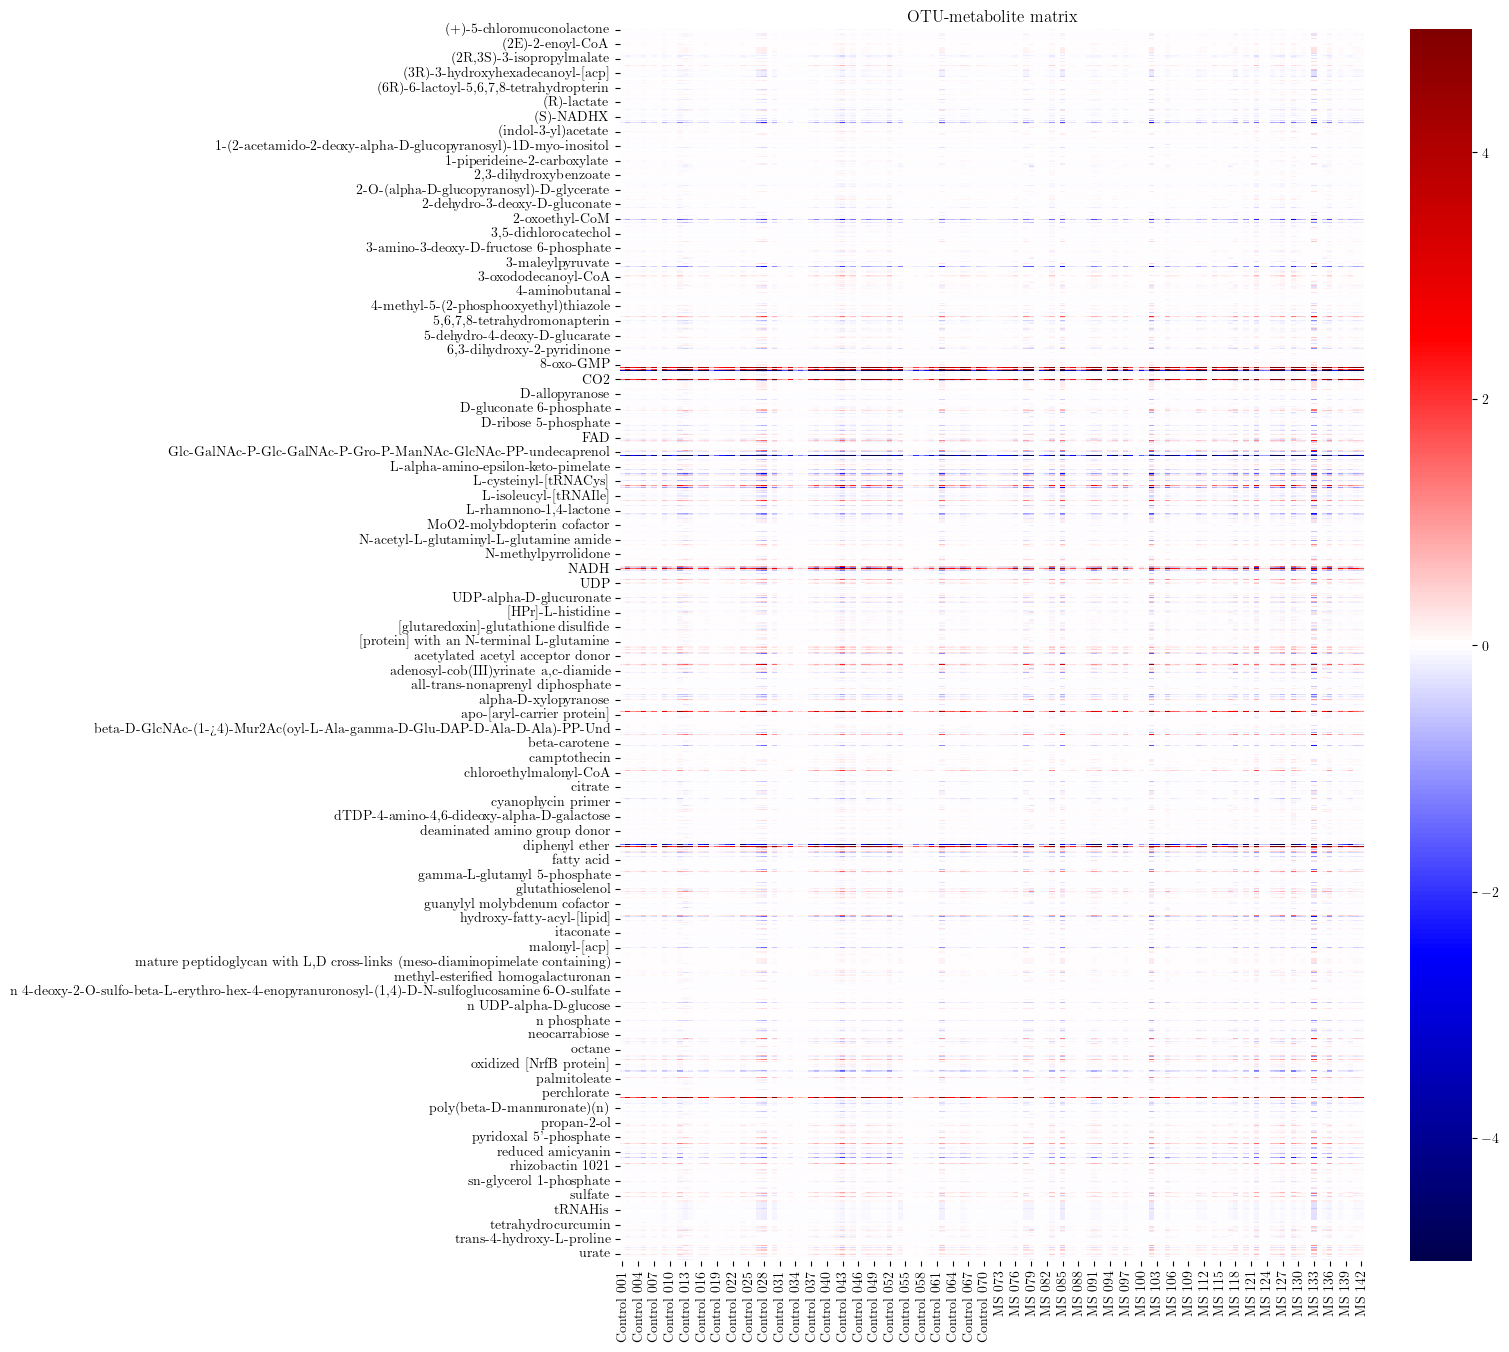

In [14]:
# Figure parameters
ax = plt.subplots(figsize=(12, 16))
plt.title("OTU-metabolite matrix")

# Plot
sns.heatmap(prod2, vmin=-5, vmax=5, cmap="seismic");
plt.savefig("plots/otu-metabolite-matrix-MS.pdf", bbox_inches="tight")